# Time Delay Accuracy Metric and MAF python interface

Phil Marshall wrote several metrics and stackers to determine time delay accuracy (A), precision (P) and success rate (f). The algorithms behind values (A, P, and f) are documented in http://arxiv.org/pdf/1409.1254.pdf (Liao et al).  In MAF they are calculated as follows: 

\begin{align}
|A|_{\rm model} &\approx 0.06\% \left(\frac{\rm cad} {\rm 3 days}  \right)^{0.0}
                          \left(\frac{\rm sea}  {\rm 4 months}\right)^{-1.0}
                          \left(\frac{\rm camp}{\rm 5 years} \right)^{-1.1} \notag \\
  P_{\rm model} &\approx 4.0\% \left(\frac{\rm cad} {\rm 3 days}  \right)^{ 0.7}
                         \left(\frac{\rm sea}  {\rm 4 months}\right)^{-0.3}
                         \left(\frac{\rm camp}{\rm 5 years} \right)^{-0.6} \notag \\
  f_{\rm model} &\approx 30\% \left(\frac{\rm cad} {\rm 3 days}  \right)^{-0.4}
                        \left(\frac{\rm sea}  {\rm 4 months}\right)^{ 0.8}
                        \left(\frac{\rm camp}{\rm 5 years} \right)^{-0.2} \notag
\end{align}

They are implemented in the [sims_maf_contrib](http://github.com/LSST-nonproject/sims_maf_contrib/tree/master/mafContrib/tdcMetric.py) github repo. 

This notebook provides a demo calculation of these metrics, using the MAF python interface (requires sims_maf version >= 1.0). 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# Import MAF modules.
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
from lsst.sims.maf.metricBundles import MetricBundle, MetricBundleGroup
# Import the contributed metrics and stackers 
import mafContrib

Set up some of the metadata, and connect to the opsim database. 

In [2]:
runName = 'enigma_1189'
dbAddress = 'sqlite:///' + runName + '_sqlite.db'
opsdb = db.OpsimDatabase(dbAddress)
outDir = 'timedelay_test'

Instantiate the metrics, stackers and slicer that we want to use. These are Phil's metrics, Phil's stackers, and the healpix slicer. Actually, since we'll just use the stackers in their default configuration, we don't need to explicitly instantiate the stackers -- MAF will handle that for us.  
Note that Phil's metric (TdcMetric) is actually a "complex" metric, as it calculates A, P, and f in one go (thus reusing the cadence/season/campaign values which must also be calculated for each set of visits), and then has 'reduce' methods that separate each of these individual results into separate values. 

In [3]:
metric = mafContrib.TdcMetric(metricName='TDC', seasonCol='season', expMJDCol='expMJD', nightCol='night')
slicer = slicers.HealpixSlicer(nside=64, lonCol='ditheredRA', latCol='ditheredDec')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


I'm also going to set the plotFuncs so that we only create the skymap and histogram for each metric result. This is an optional step - otherwise, we'd just make the angular power spectra plots too. 

In [4]:
plotFuncs = [plots.HealpixSkyMap, plots.HealpixHistogram]
slicer.plotFuncs = plotFuncs

In [5]:
sqlconstraint = ''
tdcBundle = MetricBundle(metric=metric, slicer=slicer, sqlconstraint=sqlconstraint, 
                         runName=runName)

In [6]:
resultsDb = db.ResultsDb(outDir=outDir)
bdict = {'tdc':tdcBundle}
bgroup = MetricBundleGroup(bdict, opsdb, outDir=outDir, resultsDb=resultsDb)

We can query the database, run the stackers, run the metric calculation, and run the reduce functions with 'runAll'. This would also generate summary statistics if we had defined any.

In [7]:
bgroup.runAll()

Querying database with constraint 
Found 2469307 visits
Running:  ['tdc']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Note that we now have more bundles in our bundle dictionary. These new bundles contain the results of the reduce functions - so, A/P/f separately. 

In [8]:
bdict.keys()

['tdc', 'TDC_Rate', 'TDC_Precision', 'TDC_Accuracy']

We want to set the plotDict for each of these separately, so that we can get each plot to look "just right", and then we'll make the plots.

In [9]:
minVal = 0.01
maxVal = {'Accuracy':0.03, 'Precision':5, 'Rate':40}
for k in maxVal:
    plotDict = {'xMin':minVal, 'xMax':maxVal[k], 'colorMin':minVal, 'colorMax':maxVal[k]}
    bdict['TDC_%s' %(k)].setPlotDict(plotDict)

Cannot plot object metric values with this plotter.
Cannot plot object metric values with this plotter.
Optimal bin calculation tried to make 291 bins, returning 200
Optimal bin calculation tried to make 477 bins, returning 200
Optimal bin calculation tried to make 40549 bins, returning 200


Plotting.
Plotting complete.


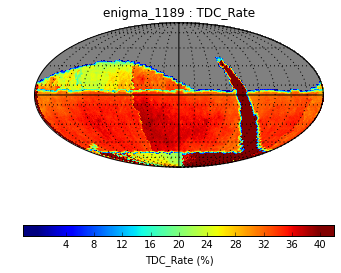

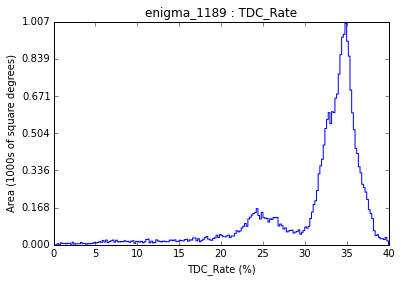

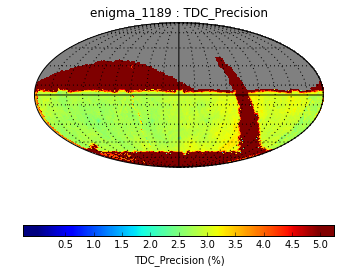

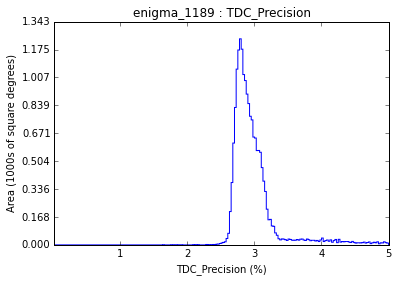

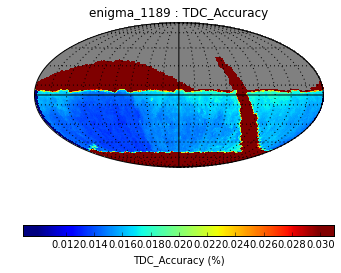

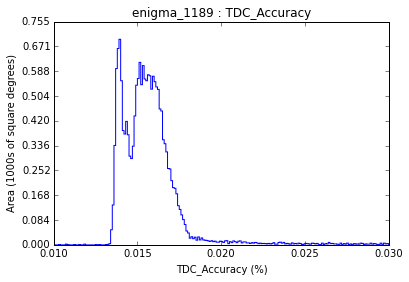

In [10]:
bgroup.plotAll(closefigs=False)

This can be repeated for alternate sqlconstraints.